In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import umap
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.kmedoids import kmedoids
import seaborn as sns
sns.set_theme(style="darkgrid")

/Users/shu/work/rocr/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def jensen_shannon_distance(p, q):
    # 入力の正規化
    p = np.asarray(p) / np.sum(p)
    q = np.asarray(q) / np.sum(q)
    
    # 中間分布の計算
    m = 0.5 * (p + q)
    
    # KLダイバージェンスの計算（ゼロ除算防止）
    kl_p = np.sum(p * np.log2(np.where(p != 0, p / m, 1)))
    kl_q = np.sum(q * np.log2(np.where(q != 0, q / m, 1)))
    
    return np.sqrt((kl_p + kl_q) / 2)

def bray_curtis_distance(p, q):
    """
    Bray-Curtis距離を計算する関数
    :param p: ベクトル1（リストまたはNumPy配列）
    :param q: ベクトル2（リストまたはNumPy配列）
    :return: Bray-Curtis距離
    """
    p = np.asarray(p)
    q = np.asarray(q)
    
    numerator = np.sum(np.abs(p - q))  # 分子: |p_i - q_i| の総和
    denominator = np.sum(p + q)       # 分母: (p_i + q_i) の総和
    
    # 分母がゼロの場合は距離を0とする（通常は非負値データでゼロにはならない）
    if denominator == 0:
        return 0.0
    
    return numerator / denominator



def custom_silhouette_score(data, labels, distance_func):
    """
    手動実装シルエットスコア
    :param data: データポイントの配列（n_samples x n_features）
    :param labels: クラスタラベルの配列
    :param distance_func: 使用する距離関数
    :return: シルエットスコアの平均値
    """
    n_samples = len(data)
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    # クラスタ数が1の場合は0を返す
    if n_clusters == 1:
        return 0.0
    
    silhouette_values = []
    
    for i in range(n_samples):
        current_point = data[i]
        current_label = labels[i]
        
        # 同一クラスタ内の距離計算
        intra_cluster_points = [data[j] for j in range(n_samples) if labels[j] == current_label and j != i]
        if not intra_cluster_points:
            a_i = 0.0
        else:
            a_i = np.mean([distance_func(current_point, p) for p in intra_cluster_points])
        
        # 他クラスタとの最小平均距離計算
        inter_cluster_distances = []
        for label in unique_labels:
            if label != current_label:
                other_cluster_points = [data[j] for j in range(n_samples) if labels[j] == label]
                mean_distance = np.mean([distance_func(current_point, p) for p in other_cluster_points])
                inter_cluster_distances.append(mean_distance)
        
        b_i = np.min(inter_cluster_distances) if inter_cluster_distances else 0.0
        
        # シルエット値の計算
        s_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) != 0 else 0.0
        silhouette_values.append(s_i)
    
    return np.mean(silhouette_values)


In [9]:
df = pd.read_csv('data.csv', index_col=0)
df2 = df.iloc[:100, :]
df.head()
# データ準備（例: 確率分布のリスト）
data = df2.values

In [ ]:
def calculate_total_distance(data, medoids, metric):
    """メドイドまでの総距離を計算"""
    total = 0.0
    for point in data:
        min_dist = float('inf')
        for m in medoids:
            dist = metric(point, data[m])
            if dist < min_dist:
                min_dist = dist
        total += min_dist
    return total

# カスタム距離指標の定義
custom_metric = distance_metric(
    type_metric.USER_DEFINED,
    func=bray_curtis_distance
)

total_distances = []


# クラスタ数の範囲
cluster_range = range(2, 10)
for k in cluster_range:
    # 初期メドイド選択（ランダム）
    initial_medoids = np.random.choice(len(data), k, replace=False)
    
    # k-medoidsクラスタリング実行
    kmedoids_instance = kmedoids(data, initial_medoids, metric=custom_metric)
    kmedoids_instance.process()
    
    # 総当たり距離計算
    total_dist = calculate_total_distance(data, kmedoids_instance.get_medoids(), custom_metric)
    
    total_distances.append(total_dist)

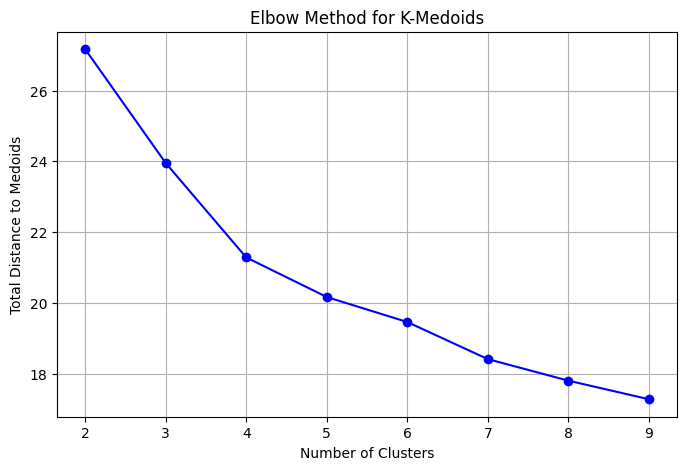

In [5]:
# エルボー法の可視化
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, total_distances, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Total Distance to Medoids')
plt.title('Elbow Method for K-Medoids')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [ ]:
# クラスタ数候補範囲
cluster_range = range(2, 10)
silhouette_scores = []

# カスタム距離指標の定義
custom_metric = distance_metric(
    type_metric.USER_DEFINED,
    func=bray_curtis_distance
)

data = df2.values

for k in cluster_range:
    # 複数回実行して最良のスコアを記録（初期値依存性対策）
    best_score = -1
    for _ in range(5):  # 5回試行
        # 初期メドイドをランダム選択
        initial_medoids = np.random.choice(len(data), k, replace=False)
        
        # k-medoidsクラスタリング実行
        kmedoids_instance = kmedoids(data, initial_medoids, metric=custom_metric)
        kmedoids_instance.process()
        
        # クラスタラベルの取得
        clusters = kmedoids_instance.get_clusters()
        labels = np.zeros(len(data))
        for cluster_idx, cluster in enumerate(clusters):
            labels[cluster] = cluster_idx
        
        # シルエットスコア計算
        score = custom_silhouette_score(data, labels, bray_curtis_distance)
        # 最良スコアを更新
        if score > best_score:
            best_score = score
    # 最良スコアを保存
    silhouette_scores.append(best_score)

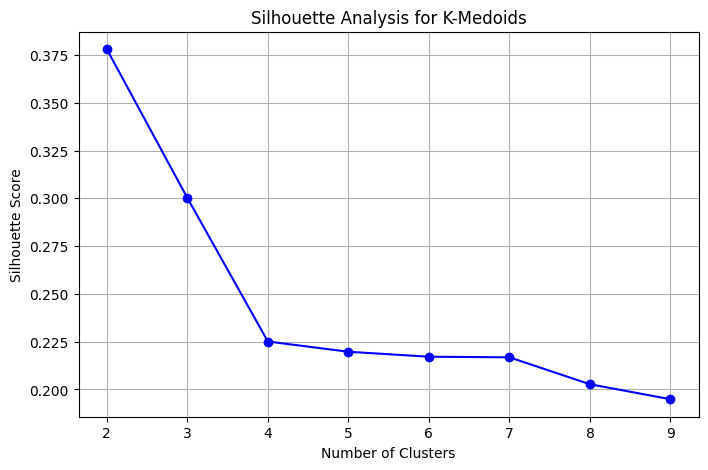

In [45]:
# 可視化
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for K-Medoids')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [10]:
reducer = umap.UMAP(n_components=2, metric="braycurtis")
# UMAPを使用して次元削減
embedding = reducer.fit_transform(data)

/Users/shu/work/rocr/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
k = 4
# カスタム距離指標の定義
custom_metric = distance_metric(
    type_metric.USER_DEFINED,
    func=bray_curtis_distance
)
#  初期メドイドをランダム選択
initial_medoids = np.random.choice(len(data), k, replace=False)

# k-medoidsクラスタリング実行
kmedoids_instance = kmedoids(data, initial_medoids, metric=custom_metric)
kmedoids_instance.process()

# クラスタラベルの取得
clusters = kmedoids_instance.get_clusters()
labels = np.zeros(len(data))
for cluster_idx, cluster in enumerate(clusters):
    labels[cluster] = cluster_idx

In [14]:
labels

array([3., 0., 3., 1., 0., 3., 3., 1., 3., 2., 1., 1., 2., 1., 2., 0., 1.,
       0., 1., 1., 2., 1., 1., 2., 0., 0., 1., 1., 2., 0., 3., 1., 2., 1.,
       3., 2., 0., 1., 1., 3., 1., 1., 0., 1., 0., 1., 0., 0., 1., 2., 1.,
       1., 0., 0., 0., 0., 1., 3., 2., 0., 1., 0., 0., 0., 0., 0., 2., 2.,
       1., 0., 0., 3., 1., 1., 1., 0., 0., 1., 1., 1., 0., 2., 2., 0., 0.,
       1., 3., 1., 2., 0., 1., 1., 2., 1., 0., 2., 3., 1., 0., 1.])

In [16]:
df_clusters = pd.DataFrame(embedding, columns=['PC1', 'PC2'])
df_clusters['Cluster'] = labels
df_clusters.head()

,PC1,PC2,Cluster
0,14.780954,-0.524747,1.0
1,9.681660,7.126802,2.0
2,14.108736,-0.596253,1.0
3,11.119392,7.118182,3.0
4,9.682798,8.478222,2.0


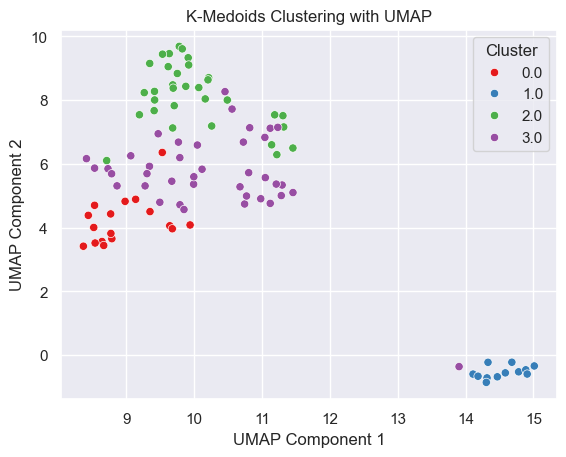

In [17]:
# プロット
sns.scatterplot(data=df_clusters, x='PC1', y='PC2', hue='Cluster', palette='Set1')
plt.title('K-Medoids Clustering with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')

In [14]:
from pyclustering.cluster import cluster_visualizer, cluster_visualizer_multidim
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES
# Read sample 'simple3' from file.
sample = df.values
# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(sample, amount_initial_centers).initialize()
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(sample, initial_centers, 20)
xmeans_instance.process()
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
# Visualize clustering results
# visualizer = cluster_visualizer_multidim()
# visualizer.append_clusters(clusters, sample)
# visualizer.append_cluster(centers, None, marker='*', markersize=10)
# visualizer.show()

In [17]:
labels = np.zeros(len(df.values))
for cluster_idx, cluster in enumerate(clusters):
    labels[cluster] = cluster_idx

In [18]:
labels

array([ 6., 17.,  3., ..., 14., 17., 11.])